In [1]:
import torch
import pyro
import matplotlib.pyplot as plt
import numpy as np

Suppose a Normal-Inverse Gamma prior: $\mu, \sigma^2 \sim NIGamma(\mu_0, \lambda, \alpha, \beta)$: 

- $p(\sigma^2; \alpha, \beta) = \frac{\beta^\alpha}{\Gamma(\alpha)} x^{-\alpha - 1} \exp \left(\frac{-\beta}{x}\right)$
- $p(\mu|\sigma^2;\mu_0, \lambda) = N(\mu; \mu_0, \frac{\sigma^2}{\lambda})$

In [2]:
### Prior parameters
mu_0 = 0.
lbda = 1.
alpha = 1.
beta = 1.

We generate data $x_1, ..., x_N \sim N(\mu, \sigma^2)$ for some unknown values of $\mu, \sigma^2$ obtained from the prior.

true_sigma_2 = 0.596257209777832
true_mean = -1.0306905508041382


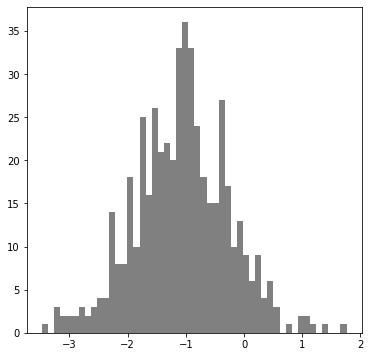

In [3]:
#Sample the prior
true_sigma_2 = pyro.distributions.InverseGamma(alpha, beta).sample()
true_mean = torch.distributions.Normal(mu_0,torch.sqrt(true_sigma_2/lbda)).sample()
print('true_sigma_2 =',true_sigma_2.item())
print('true_mean =',true_mean.item())

#Sample data 
N = 500
x_N  = torch.distributions.Normal(true_mean, torch.sqrt(true_sigma_2)).sample([N])

import matplotlib.pyplot as plt
plt.figure(figsize = (6,6))
plt.hist(x_N.numpy(), bins = 50, color = 'Grey')
plt.show()

Conveniently the Normal-Inverse Gamma is a conjugate prior for the Gaussian Likelihood, such that: 

$\mu, \sigma^2|x_1,..., x_N \sim NIGamma(\mu_N, \lambda_N, \alpha_N, \beta_N)$ where: 

- $\mu_N = \frac{\lambda\mu_0 + N\bar{x}}{\lambda + N}$
- $\lambda_N = \lambda + N$
- $\beta_N = \beta + \frac{1}{2}\sum_{i=1}^N (x_i - \bar{x})^2 + \frac{N\lambda}{2(N+\lambda)}(\bar{x} - \mu_0)^2$
- $\alpha_N = \alpha + N/2$

In [4]:
lbda_N = lbda + N
alpha_N = alpha + N/2
empirical_mean = torch.mean(x_N, dim =0) if N>0 else 0
mu_N = (lbda*mu_0 + N*empirical_mean)/lbda_N
beta_N = beta + torch.sum(torch.square(x_N-empirical_mean)).squeeze(-1)/2 + (lbda*N*(empirical_mean-mu_0)**2)/(2*lbda_N)

Since the posterior is also a Normal Inverse Gamma distribution, we can sample the posterior directly. Alternatively, we can sample this posterior via a Gibbs sampling scheme. Indeed, since both conditionals of a Normal inverse Gamma are available, we have: 
- $\mu|\sigma^2, x_1,...,x_N \sim N(\mu_N, \frac{\sigma^2}{\lambda_N})$
- $\sigma^2|\mu, x_1,...,x_N \sim IGamma(\alpha_N + \frac{1}{2}, \beta_N + \frac{\lambda_N}{2}(\mu-\mu_N)^2)$

Effective sample size of mean =  9671.1005859375
Effective sample size of sigma2 =  10362.0615234375


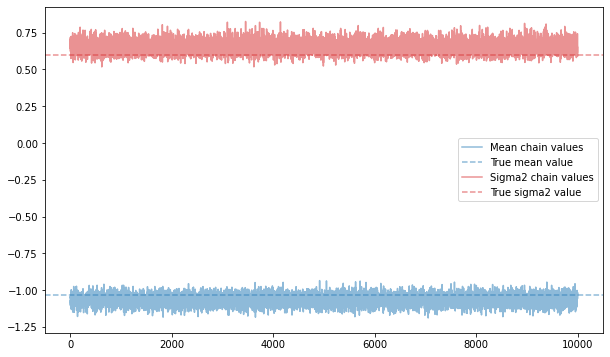

In [5]:
chain_length=10000
#Standard gibbs
list_mean_1 = []
list_sigma_2_1 = []

#initial sigma^2
estimated_sigma_2 = torch.tensor(1.)

for i in range(chain_length):
    #sample mu|sigma^2
    estimated_mean = torch.distributions.Normal(mu_N,torch.sqrt(estimated_sigma_2/lbda_N)).sample()
    list_mean_1.append(estimated_mean)
    #sample sigma^2|mu
    alpha_N_tilde = alpha_N + 1/2
    beta_N_tilde = beta_N + lbda_N*((estimated_mean - mu_N)**2)/2
    estimated_sigma_2 = pyro.distributions.InverseGamma(alpha_N_tilde, beta_N_tilde).sample()
    list_sigma_2_1.append(estimated_sigma_2)
    

figure = plt.figure(figsize = (10,6))
chain_values = torch.stack(list_mean_1)
ess = pyro.ops.stats.effective_sample_size(chain_values.unsqueeze(0), chain_dim = 0, sample_dim = 1)
plt.plot(chain_values,color ='C0', alpha = .5, label = 'Mean chain values')
plt.axhline(true_mean, color ='C0',linestyle = '--', alpha = .5, label = 'True mean value' )
print('Effective sample size of mean = '  , ess.item() )
chain_values = torch.stack(list_sigma_2_1)
ess = pyro.ops.stats.effective_sample_size(chain_values.unsqueeze(0), chain_dim = 0, sample_dim = 1)
plt.plot(chain_values, color = 'C3',alpha = .5, label = 'Sigma2 chain values')
plt.axhline(true_sigma_2, color = 'C3',linestyle = '--',alpha = .5, label = 'True sigma2 value')
print('Effective sample size of sigma2 = ', ess.item() )
plt.legend()
plt.show()

I want to write another Markov transition.

- $\mu^{(1)}_t,..., \mu^{(N)}_t \sim_{iid} p(\mu|\sigma^2_{t-1}, x_1,..., x_N)$ => Several samples of the standard Gibbs conditional
- $\sigma^2_t\sim p(\sigma)\prod_{i=1}^N p(x_i|\mu^{(i)}_t,\sigma^2)$ => Not your standard Gibbs conditional!


Normal Inverse Gamma, we have that:  
- $p(\sigma^2)\prod_{i=1}^Np(x_i|\mu^{(i)}_t,\sigma^2) = IGamma(\alpha + \frac{N}{2}, \beta + \frac{1}{2}\sum_{i=1}^N(\mu^{(i)}_t-x_i)^2)$

Effective sample size of mean =  10414.6298828125
Effective sample size of sigma2 =  10189.8994140625


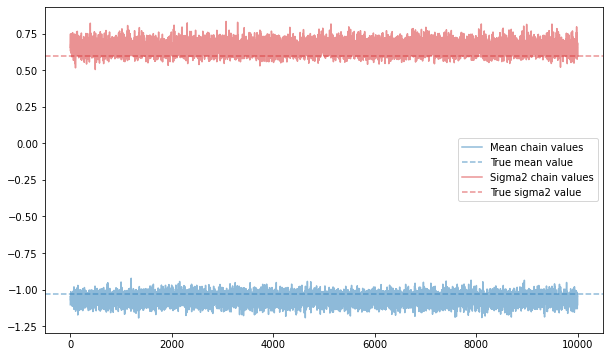

In [6]:
list_mean_2 = []
list_sigma_2_2 = []

#initial sigma^2
estimated_sigma_2 = torch.tensor(1.)
for i in range(chain_length):
    #iid samples mu1,..., mu_N|sigma^2
    estimated_mean = torch.distributions.Normal(mu_N,torch.sqrt(estimated_sigma_2/lbda_N)).sample([N])
    alpha_N_tilde = alpha + N/2
    list_mean_2.append(estimated_mean[0])
    
    #Transition sigma^2
    beta_N_tilde = beta + torch.sum((estimated_mean - x_N)**2)/2
    estimated_sigma_2 = pyro.distributions.InverseGamma(alpha_N_tilde, beta_N_tilde).sample()
    list_sigma_2_2.append(estimated_sigma_2)

figure = plt.figure(figsize = (10,6))
chain_values = torch.stack(list_mean_2)
ess = pyro.ops.stats.effective_sample_size(chain_values.unsqueeze(0), chain_dim = 0, sample_dim = 1)
plt.plot(chain_values,color ='C0', alpha = .5, label = 'Mean chain values')
plt.axhline(true_mean, color ='C0',linestyle = '--', alpha = .5, label = 'True mean value' )
print('Effective sample size of mean = '  , ess.item() )
chain_values = torch.stack(list_sigma_2_2)
ess = pyro.ops.stats.effective_sample_size(chain_values.unsqueeze(0), chain_dim = 0, sample_dim = 1)
plt.plot(chain_values, color = 'C3',alpha = .5, label = 'Sigma2 chain values')
plt.axhline(true_sigma_2, color = 'C3',linestyle = '--',alpha = .5, label = 'True sigma2 value')
print('Effective sample size of sigma2 = ', ess.item() )
plt.legend()
plt.show()

We see that this algorithm produces samples which appear to be distributed from the same posterior. Indeed, we first check the marginals by plotting:

(1) the marginal posteriors:
- $\sigma^2 \sim IGamma(\alpha_N, \beta_N)$
- $\mu \sim T_{2\alpha}(\mu, \sqrt{\frac{\beta_N}{\lambda\alpha}})$

(2) the samples obtained Gibbs sampling

(3) the samples obtained via the variant sampling scheme

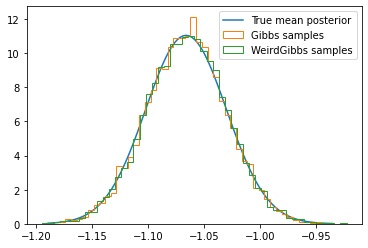

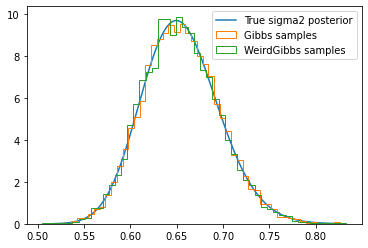

In [7]:
tt = torch.linspace(torch.min(torch.stack(list_mean_1)), torch.max(torch.stack(list_mean_1)), 100)
plt.plot(tt, torch.exp(torch.distributions.StudentT(2*alpha_N, loc= mu_N, scale = torch.sqrt(beta_N/(lbda_N*alpha_N))).log_prob(tt.unsqueeze(-1))), label = 'True mean posterior')
plt.hist(torch.stack(list_mean_1).numpy(),bins = 50, fill = False, histtype= 'step', density = True, label = 'Gibbs samples')
plt.hist(torch.stack(list_mean_2).numpy(),bins = 50, fill = False, histtype= 'step', density = True, label = 'WeirdGibbs samples')
plt.legend()
plt.show()
tt = torch.linspace(torch.min(torch.stack(list_sigma_2_1)), torch.max(torch.stack(list_sigma_2_1)), 100)
plt.plot(tt, torch.exp(pyro.distributions.InverseGamma(alpha_N, beta_N).log_prob(tt.unsqueeze(-1))), label = 'True sigma2 posterior')
plt.hist(torch.stack(list_sigma_2_1).numpy(),bins = 50, fill = False, histtype= 'step', density = True, label = 'Gibbs samples')
plt.hist(torch.stack(list_sigma_2_2).numpy(),bins = 50, fill = False, histtype= 'step', density = True, label = 'WeirdGibbs samples')
plt.legend()
plt.show()

We check the joint distribution by plotting the samples against a colormapping of the joint posterior probability.

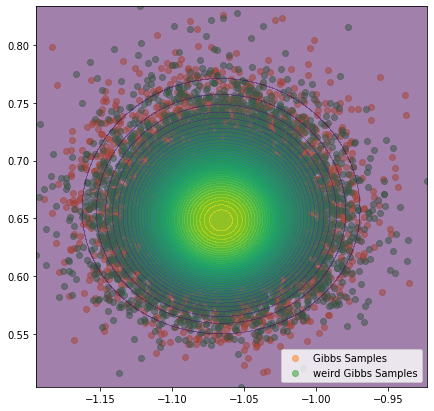

In [8]:
def joint_log_prob(samples):
    sigma = pyro.distributions.InverseGamma(alpha_N, beta_N).log_prob(samples[:,1])
    mu = torch.distributions.Normal(mu_N, torch.sqrt(samples[:,1]/lbda_N)).log_prob(samples[:,0])
    return sigma+mu

def plot_2d_function(f, x_min = -10,x_max = 10, y_min = -10, y_max = 10, levels=40,delta = 500, alpha = 0.5, new_figure = True):
    with torch.no_grad():
        if new_figure :
            plt.figure(figsize = (10,10))
        tt_x = torch.linspace(x_min, x_max, delta)
        tt_y = torch.linspace(y_min,y_max, delta)
        mesh = torch.cartesian_prod(tt_x, tt_y)
        with torch.no_grad():
            plt.contourf(tt_x,tt_y,f(mesh).numpy().reshape(delta,delta).T, alpha = alpha, levels = levels)
            
y_min = torch.min(torch.stack(list_sigma_2_1 + list_sigma_2_2))
y_max = torch.max(torch.stack(list_sigma_2_1 + list_sigma_2_2))
x_min = torch.min(torch.stack(list_mean_1 + list_mean_2))
x_max = torch.max(torch.stack(list_mean_1 + list_mean_2))
delta = 75
fig = plt.figure(figsize = (7,7))
plt.scatter(torch.stack(list_mean_1).numpy(),torch.stack(list_sigma_2_1).numpy(), alpha = .5, color = 'C1', label = 'Gibbs Samples')
plt.scatter(torch.stack(list_mean_2).numpy(),torch.stack(list_sigma_2_2).numpy(), alpha = .5, color = 'C2', label = 'weird Gibbs Samples')
plot_2d_function(lambda samples: torch.exp(joint_log_prob(samples)), y_min = y_min, y_max = y_max, x_min = x_min, x_max= x_max, new_figure= False)
plt.legend()
plt.show()


Better visualisation with histograms: we compare the joint posterior probability with histograms of the samples produced by the two approaches. 

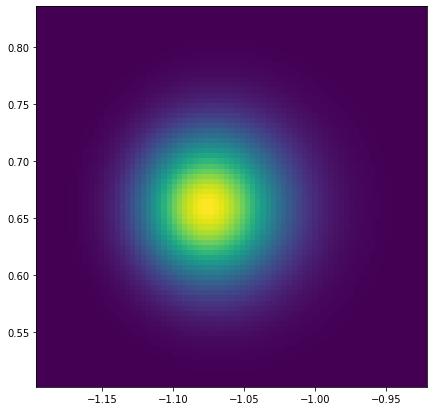

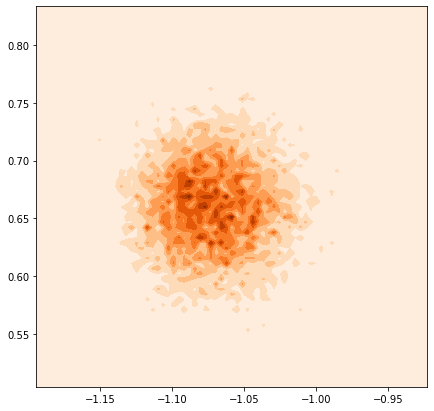

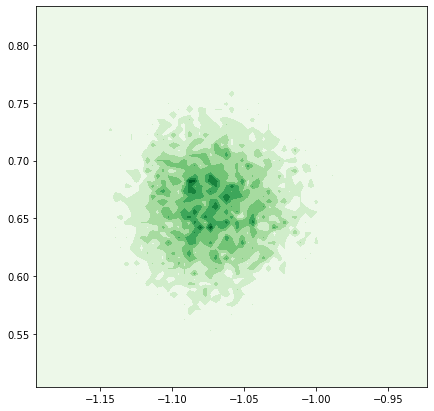

In [9]:
tt_x, tt_y = torch.linspace(x_min,x_max, delta), torch.linspace(y_min,y_max, delta)
mesh = torch.cartesian_prod(tt_x, tt_y)
hist = torch.exp(joint_log_prob(mesh)).reshape(delta, delta)
fig = plt.figure(figsize = (7,7))
plt.pcolormesh(tt_x, tt_y,hist.numpy())
plt.show()
hist_1 = np.histogram2d(torch.stack(list_mean_1).numpy(), torch.stack(list_sigma_2_1).numpy(),range = ((x_min,x_max),(y_min,y_max)),bins = (delta, delta), density = True)
fig = plt.figure(figsize = (7,7))
plt.contourf(tt_x,tt_y, hist_1[0], cmap  = 'Oranges')
plt.show()
hist_2 = np.histogram2d(torch.stack(list_mean_2).numpy(), torch.stack(list_sigma_2_2).numpy(),range = ((x_min,x_max),(y_min,y_max)),bins = (delta, delta), density = True)
fig = plt.figure(figsize = (7,7))
plt.contourf(tt_x,tt_y, hist_2[0], cmap  = 'Greens')
plt.show()

As exepected, the Gibbs samples are distributed according to the posterior.

But oddly, the other sampling scheme (weird gibbs) also seems to provide with posterior samples.